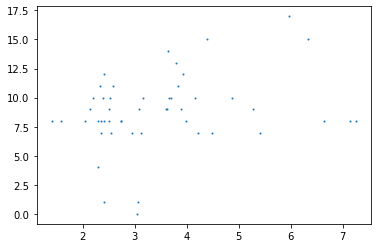

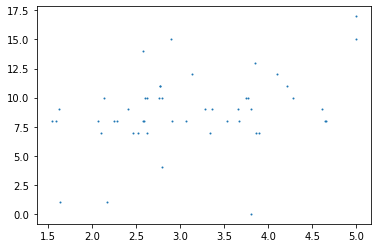

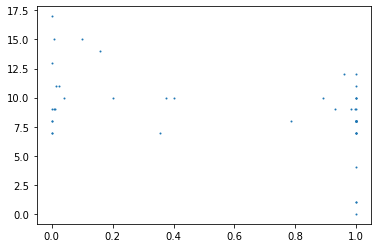

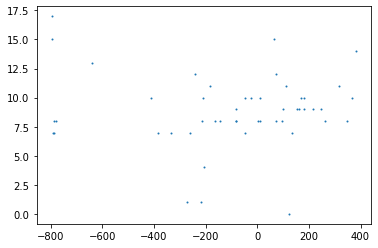

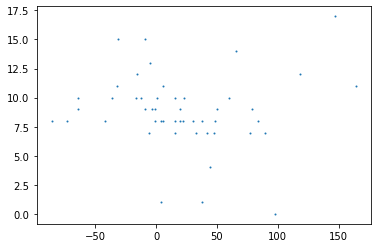

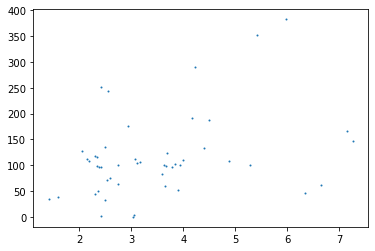

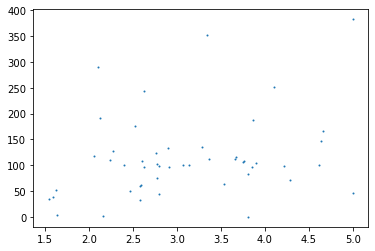

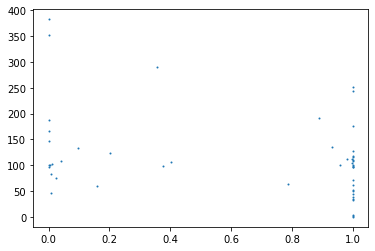

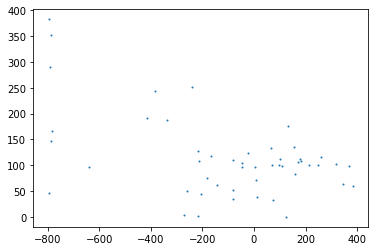

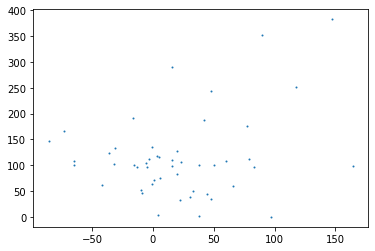

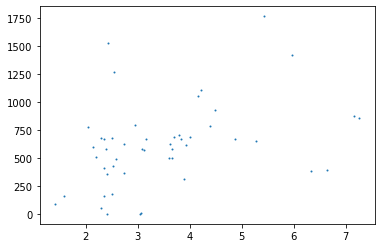

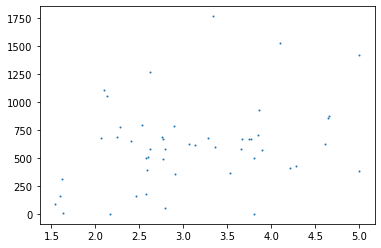

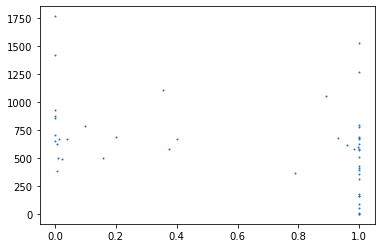

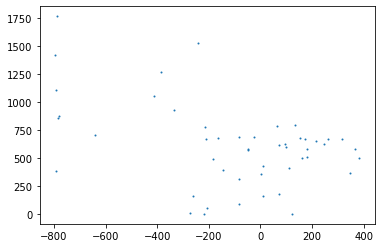

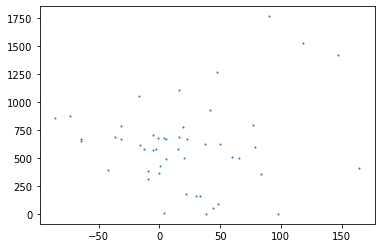

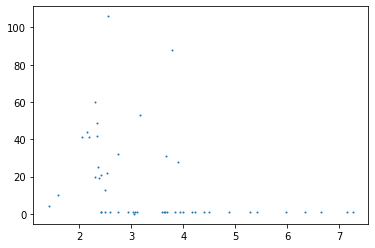

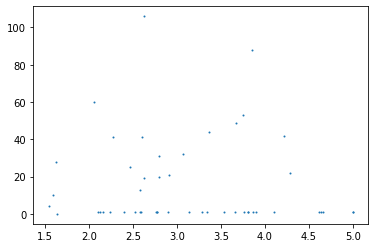

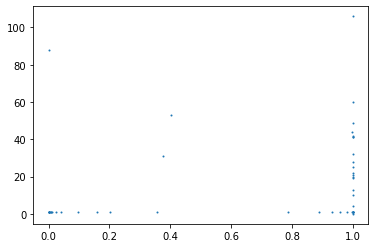

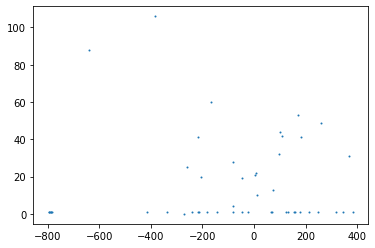

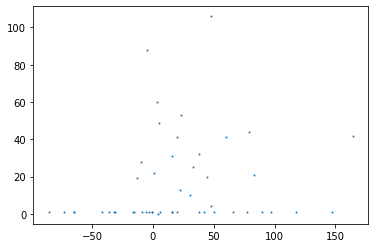

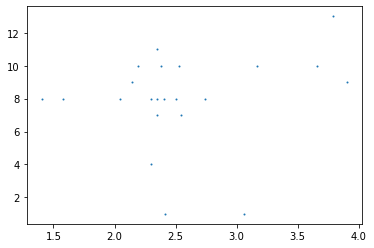

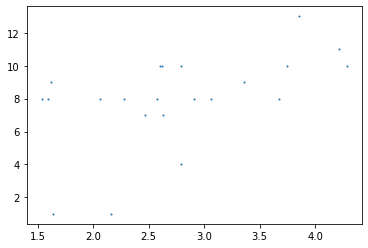

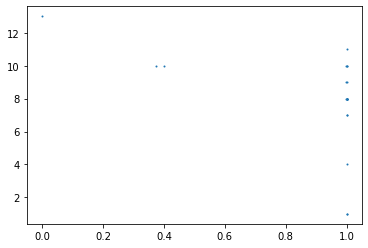

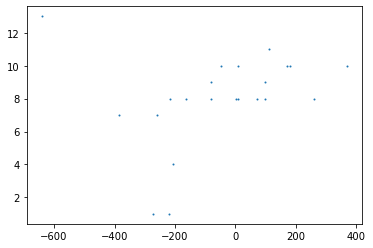

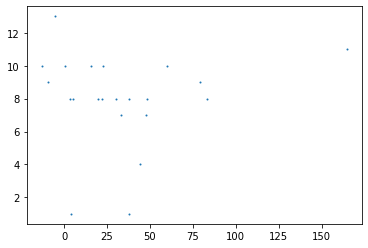

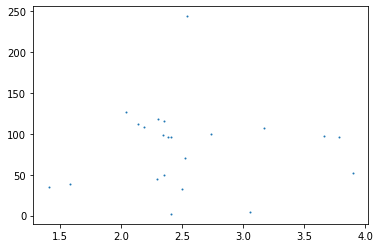

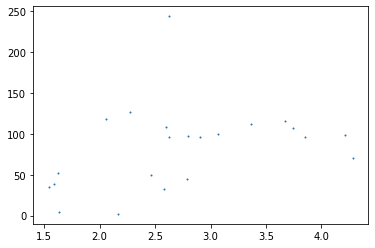

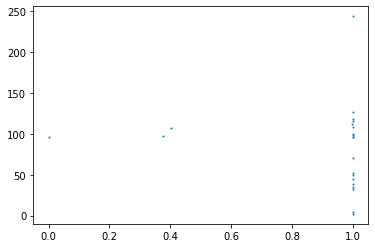

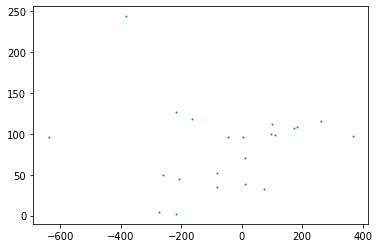

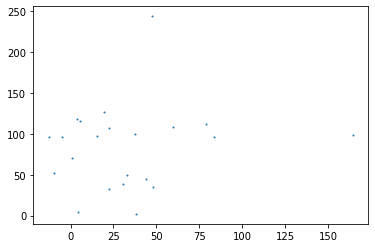

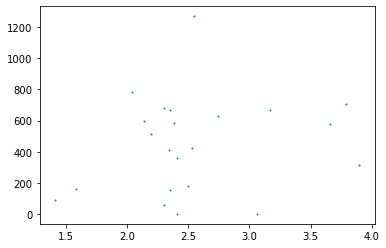

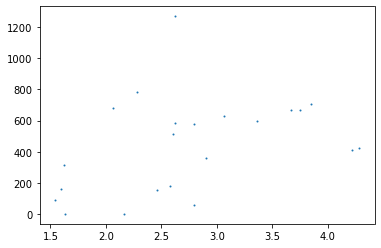

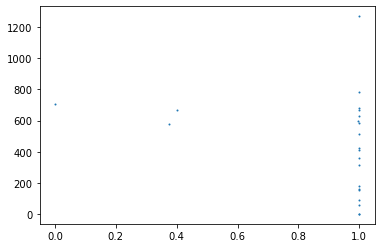

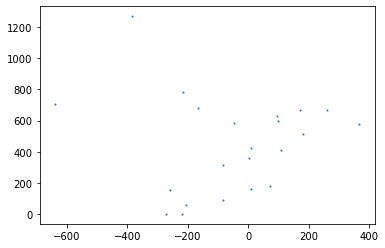

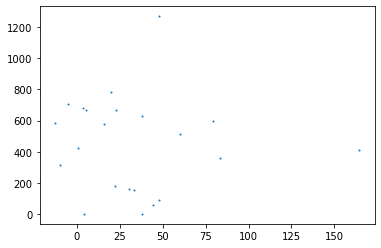

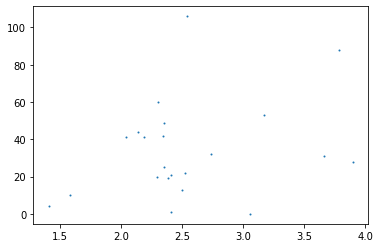

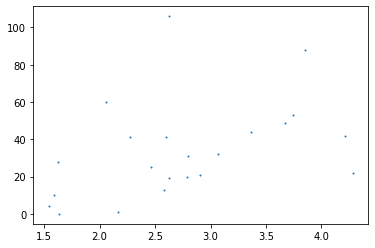

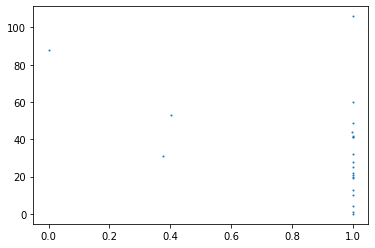

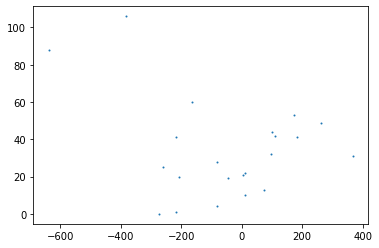

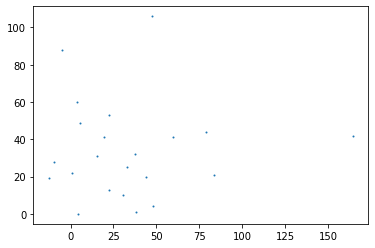

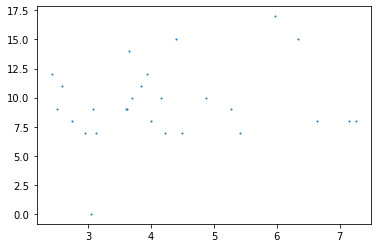

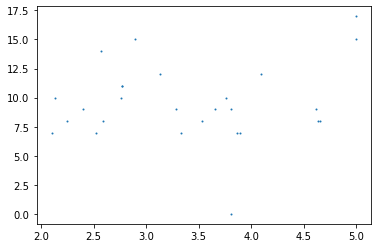

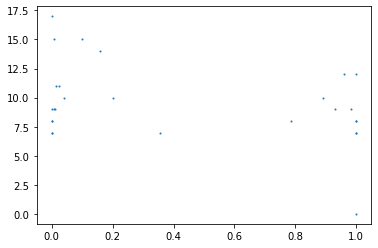

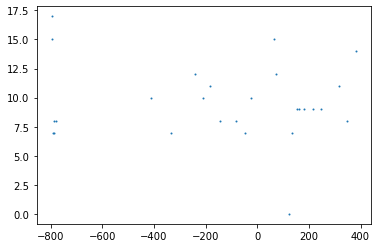

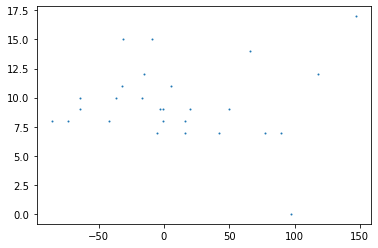

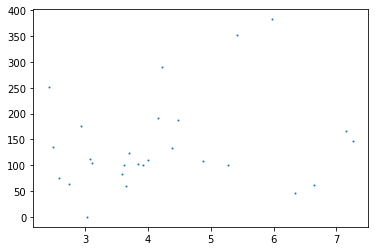

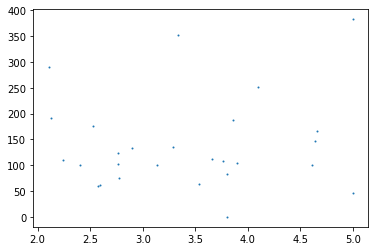

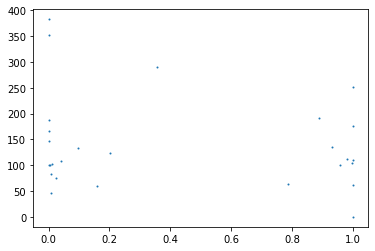

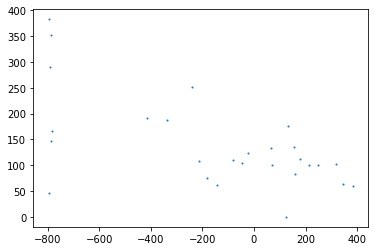

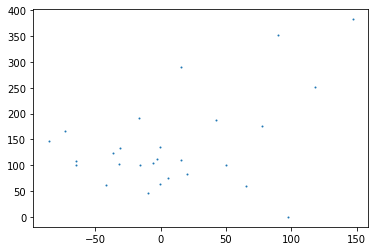

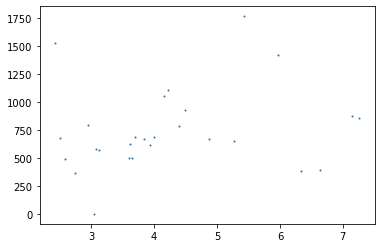

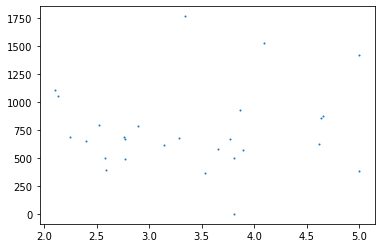

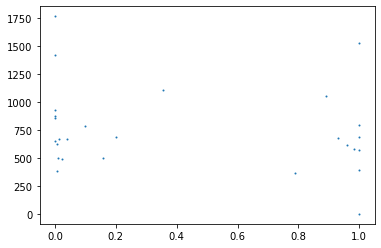

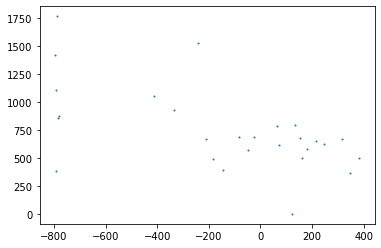

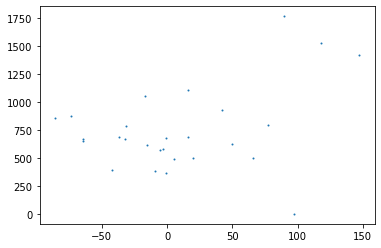

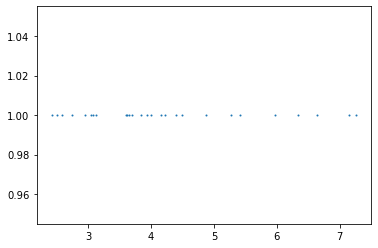

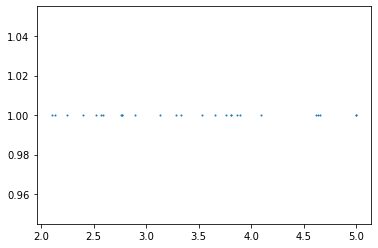

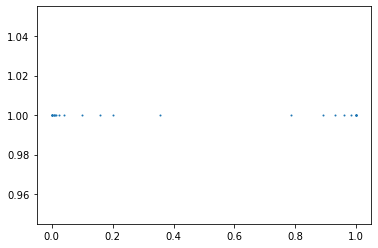

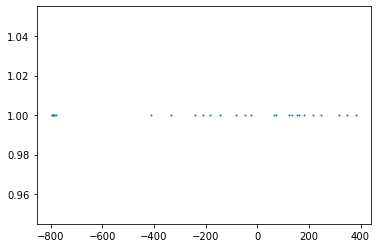

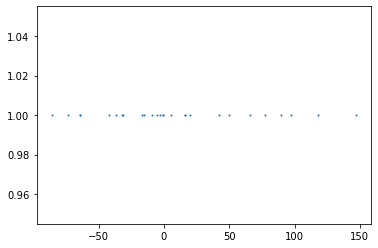

In [1]:
%load_ext autoreload
%autoreload 2

from shared import Db, Fn

from main.ai import ai_setups, zero_setup
from main.data import Mol, data
from main.tree import JsonTree, Tree, TreeTypes
from main.types import AiInput, Setup
from main.score import Score

from IPython.display import display, HTML
from typing import Any

import numpy as np
import pandas
from main.utils import fn_txt


import matplotlib.pyplot as plt

def scatter_plot(pairs: list[tuple[Any, Any]]):
    xs = [x for x, _y in pairs]
    ys = [y for _x, y in pairs]
    plt.figure()
    plt.scatter(xs, ys, s=1, linewidths=1)
    plt.show()


def get_stats(mol: Mol):
    ai_input: AiInput = {"smiles": mol.smiles, "setup": zero_setup}
    json_tree = db.read(["ai_postprocess", ai_input], JsonTree)
    assert json_tree
    tree = Tree(json_tree)
    assert len(tree.expandable) == 1
    assert len(tree.in_stock) == 0
    return tree.expandable[0].score, tree.type, tree.stats()

filters: list[Fn[TreeTypes, bool]] = [
    lambda _type: True,
    lambda type: type == "internal",
    lambda type: type == "not_solved"
]

with Db("db", True) as db:
    mols = data()
    tree_stats = [get_stats(mol) for mol in mols]
    for filter in filters:
        display(HTML("============================================="))
        display(HTML("filter: " + fn_txt(filter)))
        for characteristic in ("max_depth", "max_width", "node_count", "not_solved_count"):
            display(HTML(characteristic))
            rows: list[tuple[str, float,float,float]] = []
            pairs_score_characteristic: list[tuple[Score, int]] = [(score, stats[characteristic]) for score, type, stats in tree_stats if filter(type)]
            for score_name, getter in Score.getters():
                display(HTML(score_name))
                pairs_score_char_value = [(getter(score), char_value) for score, char_value in pairs_score_characteristic]
                scatter_plot(pairs_score_char_value)